In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline 

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


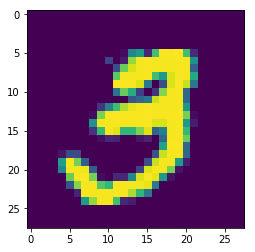

In [3]:
img = np.array(mnist.train.images[753])
plt.imshow(img.reshape(28,28))

In [4]:
def batch_norm(X, scale, offset, axes, is_train):
    # 予測のときにはそのまんまの値を返す
    if is_train is False:
        return X
    
    epsilon = 1e-5
    mean, variance = tf.nn.moments(X, axes)
    return tf.nn.batch_normalization(X, mean, variance, offset, scale, epsilon)

class Generator():
    def __init__(self):
        
        # Generator parameter        
        self.gen_w1 = tf.Variable(tf.truncated_normal(shape=[100,128],stddev=0.02,dtype=tf.float32),name="gen_w1")
        self.gen_b1 = tf.Variable(tf.truncated_normal(shape=[128],stddev=0.02,dtype=tf.float32),name="gen_b1")
        
        self.gen_w2 = tf.Variable(tf.truncated_normal([128,256],stddev=0.02,dtype=tf.float32),name="gen_w2")
        self.gen_b2 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.02,dtype=tf.float32),name="gen_b2")
        
        self.gen_w3 = tf.Variable(tf.truncated_normal([256,512],stddev=0.02,dtype=tf.float32),name="gen_w3")
        self.gen_b3 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.02,dtype=tf.float32),name="gen_b3")
        
        self.gen_w4 = tf.Variable(tf.truncated_normal([512,28*28],stddev=0.02,dtype=tf.float32),name="gen_w4")
        self.gen_b4 = tf.Variable(tf.truncated_normal(shape=[28*28],stddev=0.02,dtype=tf.float32),name="gen_b4")
        
        self.gen_scale_w1 = tf.Variable(tf.ones([128]),name="gen_scale_w1")
        self.gen_offset_w1 = tf.Variable(tf.zeros([128]),name="gen_offset_w1")
        
        self.gen_scale_w2 = tf.Variable(tf.ones([256]),name="gen_scale_w2")
        self.gen_offset_w2 = tf.Variable(tf.zeros([256]),name="gen_offset_w2")
        
        self.gen_scale_w3 = tf.Variable(tf.ones([512]),name="gen_scale_w3")
        self.gen_offset_w3 = tf.Variable(tf.zeros([512]),name="gen_offset_w3")
        
        self.keep_prob = tf.placeholder(tf.float32)
        
    def run(self,z,is_train):
        
        h1 = tf.nn.leaky_relu(tf.nn.xw_plus_b(z,self.gen_w1,self.gen_b1),alpha=0.2)
        h1 = batch_norm(h1,self.gen_scale_w1,self.gen_offset_w1,[0],is_train)
        
        h2 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h1,self.gen_w2,self.gen_b2),alpha=0.2)
        h2 = batch_norm(h2,self.gen_scale_w2,self.gen_offset_w2,[0],is_train)
        
        h3 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h2,self.gen_w3,self.gen_b3),alpha=0.2)
        h3 = batch_norm(h3,self.gen_scale_w3,self.gen_offset_w3,[0],is_train)
        h3_drop = tf.nn.dropout(h3, self.keep_prob)
        
        fc = tf.nn.sigmoid(tf.nn.xw_plus_b(h3_drop,self.gen_w4,self.gen_b4))
        
        return fc

class Discrimitor():
    def __init__(self):
        
        # Discrimitor parameter
        self.dis_w1 = tf.Variable(tf.truncated_normal([28*28,512],stddev=0.02,dtype=tf.float32),name="dis_w1")
        self.dis_b1 = tf.Variable(tf.truncated_normal([512],stddev=0.02,dtype=tf.float32),name="dis_b1")
        
        self.dis_w2 = tf.Variable(tf.truncated_normal([512,256],stddev=0.02,dtype=tf.float32),name="dis_w2")
        self.dis_b2 = tf.Variable(tf.truncated_normal([256],stddev=0.02,dtype=tf.float32),name="dis_b2")
        
        self.dis_w3 = tf.Variable(tf.truncated_normal([256,128],stddev=0.02,dtype=tf.float32),name="dis_w3")
        self.dis_b3 = tf.Variable(tf.truncated_normal([128],stddev=0.02,dtype=tf.float32),name="dis_b3")
        
        self.dis_w4 = tf.Variable(tf.truncated_normal([128,1],stddev=0.02,dtype=tf.float32),name="dis_w4")
        self.dis_b4 = tf.Variable(tf.truncated_normal([1],stddev=0.02,dtype=tf.float32),name="dis_b4")
        
    def run(self,x):

        h1 = tf.nn.leaky_relu(tf.nn.xw_plus_b(x,self.dis_w1,self.dis_b1),alpha=0.2)
        h2 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h1,self.dis_w2,self.dis_b2),alpha=0.2)   
        h3 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h2,self.dis_w3,self.dis_b3),alpha=0.2)
        
        fc = tf.nn.xw_plus_b(h3,self.dis_w4,self.dis_b4)
        
        return fc
    
class GAN():
    def __init__(self):
        
        self.is_train = tf.placeholder(tf.bool)
        self.input_X = tf.placeholder(tf.float32, shape=(None,28*28))
        
        # t0は0のラベルを格納し、t1は1のラベルを格納する
        self.label_t0 = tf.placeholder(tf.float32, shape=(None,1))
        self.label_t1 = tf.placeholder(tf.float32, shape=(None,1))
        
        # Generator
        self.generator = Generator()
        # 生成モデルに必要なノイズの入れ物
        self.gen_z = tf.placeholder(tf.float32, shape=(None,100))
        
        # Discrimitor 
        self.discrimitor = Discrimitor()
        
        # weight decay
        gen_norm_term = tf.nn.l2_loss(self.generator.gen_w2) + tf.nn.l2_loss(self.generator.gen_w3) + tf.nn.l2_loss(self.generator.gen_w4)
        gen_lambda_ = 0.001
        
        dis_norm_term = tf.nn.l2_loss(self.discrimitor.dis_w2) + tf.nn.l2_loss(self.discrimitor.dis_w3)
        dis_lambda_ = 0.001
        
        # 訓練データの識別予測
        input_X = self.discrimitor.run(self.input_X)
        # 生成されたデータの識別yosoku
        generated_X = self.discrimitor.run(self.generator.run(self.gen_z,self.is_train))
        
        self.dis_entropy_X = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t1, logits=input_X)  
        self.dis_entropy_G = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t0, logits=generated_X)   
        self.dis_loss = tf.reduce_mean(self.dis_entropy_X + self.dis_entropy_G) + dis_norm_term*dis_lambda_
        
        self.gen_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t1,logits=generated_X)
        self.gen_loss = tf.reduce_mean(self.gen_entropy) + gen_norm_term*gen_lambda_
        
        # 最適化する際にDならDのみのパラメータを、GならGのみのパラメータを更新するようにしたいのでモデル別の変数を取得する
        dis_vars = [x for x in tf.trainable_variables() if "dis_" in x.name]
        gen_vars = [x for x in tf.trainable_variables() if "gen_" in x.name]
        
        # 識別モデルDの最適化
        self.opt_d = tf.train.MomentumOptimizer(0.1, momentum=0.5).minimize(self.dis_loss,var_list=[dis_vars])
        # 生成モデルGの最適化
        self.opt_g = tf.train.MomentumOptimizer(0.1, momentum=0.5).minimize(self.gen_loss,var_list=[gen_vars])
        
    def train(self
                  , X_train = None 
                  , batch_size = 100
                  , epoch_num = 1000
                  , savepath = './mnist_GAN/'
                  , init = False):
        
        if X_train is None:
            raise TypeError("X_train is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(savepath)
        if not(p.is_dir()):
            p.mkdir()

        sess = tf.Session()
        if(init):
            sess.run(tf.global_variables_initializer())
        
        step = len(X_train) // batch_size
        #step = mnist.train.num_examples // batch_size
        
        # 正解ラベルのミニバッチ
        t1_batch = np.ones((batch_size,1),dtype=np.float32)
        t0_batch = np.zeros((batch_size,1),dtype=np.float32)
        
        for epoch in range(epoch_num):
            
            perm = np.random.permutation(len(X_train))
            for k in range(step):
                #X_batch = mnist.train.next_batch(batch_size)[0] /255.
                X_batch = X_train[perm][k*batch_size:(k+1)*batch_size]
                
                # Train Discrimitor
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(0,1, size=[batch_size, 100]).astype(np.float32)

                sess.run(self.opt_d, feed_dict = {self.input_X:X_batch
                                                                          , self.is_train:False
                                                                          , self.gen_z:noise_z
                                                                          , self.generator.keep_prob:1.0
                                                                          , self.label_t1:t1_batch
                                                                          , self.label_t0:t0_batch})
                
                #if k % (step//10) == 0:
                # Train Generator
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(0,1, size=[batch_size, 100]).astype(np.float32)
                sess.run(self.opt_g, feed_dict = {self.gen_z:noise_z
                                                                          , self.is_train:True
                                                                          , self.generator.keep_prob:0.5
                                                                          , self.label_t1:t1_batch})
            
            noise_z = np.random.uniform(0,1, size=[batch_size, 100]).astype(np.float32)
            train_dis_loss = sess.run(self.dis_loss, feed_dict = {self.input_X:X_batch
                                                                                                      , self.is_train:False
                                                                                                      , self.gen_z:noise_z
                                                                                                      , self.generator.keep_prob:1.0
                                                                                                      , self.label_t1:t1_batch
                                                                                                      , self.label_t0:t0_batch})

            train_gen_loss = sess.run(self.gen_loss, feed_dict ={self.gen_z:noise_z
                                                                                                      , self.is_train:False
                                                                                                      , self.generator.keep_prob:1.0
                                                                                                      , self.label_t1:t1_batch})

            print("[Train] epoch: %d, dis loss: %f , gen loss : %f" % (epoch, train_dis_loss, train_gen_loss))
            
            # 10epoch終了毎に生成モデルから1枚の画像を生成する
            if epoch % 10 == 0:
                noise_z = np.random.uniform(0,1, size=[1, 100]).astype(np.float32)

                z_const = tf.constant(noise_z,dtype=tf.float32)
                gen_imgs = sess.run(self.generator.run(z_const, is_train=False),feed_dict={self.generator.keep_prob:1.0}) * 255
                Image.fromarray(gen_imgs[0].reshape(28,28)).convert('RGB').save(
                        str(p.absolute())+'/generate_img_epoch{0}.jpg'.format(epoch)
                )

In [5]:
model = GAN()

In [6]:
# 任意の数字のみを学習させたいとき用
X_train = np.r_[mnist.train.images[np.where(mnist.train.labels[:,5]  > 0)] ,mnist.test.images[np.where(mnist.test.labels[:,5]  > 0)]] / 255.

# 全体を学習したい用
#X_train = np.r_[mnist.train.images,mnist.test.images] / 255.

In [7]:
model.train(X_train = X_train
                    , batch_size=100
                    , epoch_num=300
                    , savepath = './mnist_5_generate_imgs/'
                    , init=True)

[Train] epoch: 0, dis loss: 0.078119 , gen loss : 7.680473
[Train] epoch: 1, dis loss: 0.085785 , gen loss : 3.561870
[Train] epoch: 2, dis loss: 1.359633 , gen loss : 0.912048
[Train] epoch: 3, dis loss: 1.401109 , gen loss : 0.896579
[Train] epoch: 4, dis loss: 1.387708 , gen loss : 0.903403
[Train] epoch: 5, dis loss: 1.385955 , gen loss : 0.903940
[Train] epoch: 6, dis loss: 1.375986 , gen loss : 0.901337
[Train] epoch: 7, dis loss: 1.417405 , gen loss : 0.876229
[Train] epoch: 8, dis loss: 1.422792 , gen loss : 0.866282
[Train] epoch: 9, dis loss: 1.429992 , gen loss : 0.867796
[Train] epoch: 10, dis loss: 1.417564 , gen loss : 0.873641
[Train] epoch: 11, dis loss: 1.408666 , gen loss : 0.874550
[Train] epoch: 12, dis loss: 1.398145 , gen loss : 0.875390
[Train] epoch: 13, dis loss: 1.388433 , gen loss : 0.890254
[Train] epoch: 14, dis loss: 1.413883 , gen loss : 0.862240
[Train] epoch: 15, dis loss: 1.406475 , gen loss : 0.863806
[Train] epoch: 16, dis loss: 1.405181 , gen loss :

[Train] epoch: 137, dis loss: 1.387306 , gen loss : 0.758596
[Train] epoch: 138, dis loss: 1.381018 , gen loss : 0.759950
[Train] epoch: 139, dis loss: 1.377271 , gen loss : 0.761213
[Train] epoch: 140, dis loss: 1.373236 , gen loss : 0.760845
[Train] epoch: 141, dis loss: 1.433924 , gen loss : 1.058788
[Train] epoch: 142, dis loss: 1.373551 , gen loss : 0.761189
[Train] epoch: 143, dis loss: 1.472109 , gen loss : 0.668246
[Train] epoch: 144, dis loss: 1.387705 , gen loss : 0.731920
[Train] epoch: 145, dis loss: 1.385282 , gen loss : 0.754760
[Train] epoch: 146, dis loss: 1.382266 , gen loss : 0.756895
[Train] epoch: 147, dis loss: 1.377910 , gen loss : 0.757544
[Train] epoch: 148, dis loss: 1.381461 , gen loss : 0.745199
[Train] epoch: 149, dis loss: 1.376939 , gen loss : 0.757952
[Train] epoch: 150, dis loss: 1.374464 , gen loss : 0.759460
[Train] epoch: 151, dis loss: 1.383846 , gen loss : 0.752413
[Train] epoch: 152, dis loss: 1.381500 , gen loss : 0.753606
[Train] epoch: 153, dis 

[Train] epoch: 272, dis loss: 1.438726 , gen loss : 0.669432
[Train] epoch: 273, dis loss: 1.390349 , gen loss : 0.764823
[Train] epoch: 274, dis loss: 1.377946 , gen loss : 0.770078
[Train] epoch: 275, dis loss: 1.387002 , gen loss : 0.763811
[Train] epoch: 276, dis loss: 1.386519 , gen loss : 0.763224
[Train] epoch: 277, dis loss: 1.383255 , gen loss : 0.763840
[Train] epoch: 278, dis loss: 1.383986 , gen loss : 0.761962
[Train] epoch: 279, dis loss: 1.419216 , gen loss : 0.741341
[Train] epoch: 280, dis loss: 1.391592 , gen loss : 0.756506
[Train] epoch: 281, dis loss: 1.389952 , gen loss : 0.756011
[Train] epoch: 282, dis loss: 1.388891 , gen loss : 0.755466
[Train] epoch: 283, dis loss: 1.387570 , gen loss : 0.755186
[Train] epoch: 284, dis loss: 1.386727 , gen loss : 0.754996
[Train] epoch: 285, dis loss: 1.384513 , gen loss : 0.755326
[Train] epoch: 286, dis loss: 1.383948 , gen loss : 0.755439
[Train] epoch: 287, dis loss: 1.383123 , gen loss : 0.755076
[Train] epoch: 288, dis 